In [7]:
import numpy as np
from scipy.stats import multivariate_normal as MVN
import matplotlib.pyplot as plt
from scipy.optimize import root, fsolve, minimize
from numpy.linalg import norm, solve, inv, det
from numpy import log, zeros, eye, exp, cos, sin, pi
from scipy.stats import uniform as udist
from numpy.random import rand
from matplotlib.colors import ListedColormap

from utils import prep_contour
from Manifolds.GeneralizedEllipse import GeneralizedEllipse

In [16]:
# Horizonal Gaussian
μ1 = np.array([0, 0])
Σ1 = np.array([[10.0, 0.0], [0.0, 0.1]])
π1 = MVN(μ1, Σ1)

# Vertical Gaussian
μ2 = np.array([0, 0])
Σ2 = np.array([[0.1, 0.0], [0.0, 10.0]])
π2 = MVN(μ2, Σ2)

# Rotation matrices 
R45  = (np.sqrt(2)/2) * np.array([[1, -1], [1, 1]]) # Rotates 45 degrees counter-clockwise
R225 = np.array([[cos(pi/8), -sin(pi/8)], [sin(pi/8), cos(pi/8)]])

# TopRight-BottomLeft Gaussian
μ3 = R45@μ1
Σ3 = R45@Σ1@R45.T
π3 = MVN(μ3, Σ3)

# TopRight-BottomLeft Gaussian
μ3 = R45@μ1
Σ3 = R45@Σ1@R45.T
π3 = MVN(μ3, Σ3)

# TopLeft-BottomRight Gaussian
μ4 = R45@μ2
Σ4 = R45@Σ2@R45.T
π4 = MVN(μ4, Σ4)

# TopLeft-Bottom Right (22.5 degrees from vertical)
μ5 = R225@μ2
Σ5 = R225@Σ2@R225.T
π5 = MVN(μ5, Σ5)

# TopRight-BottomLeft (22.5 from topright-bottomleft)
μ6 = R225@μ3
Σ6 = R225@Σ3@R225.T
π6 = MVN(μ6, Σ6)

# Topright-Bottom Left( 22.5 from horizontal)
μ7 = R225@μ1
Σ7 = R225@Σ1@R225.T
π7 = MVN(μ7, Σ7)

# Topleft-Bottomright (22.5 from TopLeft BottomRight)
μ8 = R225@μ4
Σ8 = R225@Σ4@R225.T
π8 = MVN(μ8, Σ8)


# Store values
Σ1inv = inv(Σ1)
Σ2inv = inv(Σ2)
Σ3inv = inv(Σ3)
Σ4inv = inv(Σ4)
Σ5inv = inv(Σ5)
Σ6inv = inv(Σ6)
Σ7inv = inv(Σ7)
Σ8inv = inv(Σ8)

z0 = 0.026
y = log(z0)
f = lambda x: np.log(π1.pdf(x) + π2.pdf(x) + π3.pdf(x) + π4.pdf(x) + π5.pdf(x) + π6.pdf(x) + π7.pdf(x) + π8.pdf(x))
def grad(x):
    """Computes gradient of f."""
    # Exponential of quadratic products
    eqp1 = exp(-0.5*x.dot(Σ1inv).dot(x))
    eqp2 = exp(-0.5*x.dot(Σ2inv).dot(x))
    eqp3 = exp(-0.5*x.dot(Σ3inv).dot(x))
    eqp4 = exp(-0.5*x.dot(Σ4inv).dot(x))
    eqp5 = exp(-0.5*x.dot(Σ5inv).dot(x))
    eqp6 = exp(-0.5*x.dot(Σ6inv).dot(x))
    eqp7 = exp(-0.5*x.dot(Σ7inv).dot(x))
    eqp8 = exp(-0.5*x.dot(Σ8inv).dot(x))
    return ((eqp1*Σ1inv + eqp2*Σ2inv + eqp3*Σ3inv + eqp4*Σ4inv + eqp5*Σ5inv + eqp6*Σ6inv + eqp7*Σ7inv + eqp8*Σ8inv)/(eqp1+eqp2+eqp3+eqp4+eqp5+eqp6+eqp7+eqp8)).dot(x)

In [33]:
def sample_near_manifold(maxiter=100):
    u = np.random.rand()
    ellipse1 = GeneralizedEllipse(μ1, Σ1, 0.08)
    ellipse2 = GeneralizedEllipse(μ2, Σ2, 0.08)
    ellipse3 = GeneralizedEllipse(μ3, Σ3, 0.08)
    ellipse4 = GeneralizedEllipse(μ4, Σ4, 0.08)
    ellipse5 = GeneralizedEllipse(μ5, Σ5, 0.08)
    ellipse6 = GeneralizedEllipse(μ6, Σ6, 0.08)
    ellipse7 = GeneralizedEllipse(μ7, Σ7, 0.08)
    ellipse8 = GeneralizedEllipse(μ8, Σ8, 0.08)
    if u < 0.125:
        return ellipse1.sample()
    elif 0.125 <= u < 0.25:
        return ellipse2.sample()
    elif 0.25 <= u < 0.375:
        return ellipse3.sample()
    elif 0.375 <= u < 0.5:
        return ellipse4.sample()
    elif 0.5 <= u < 0.625:
        return ellipse5.sample()
    elif 0.625 <= u < 0.75:
        return ellipse6.sample()
    elif 0.75 <= u < 0.875:
        return ellipse7.sample()
    else:
        return ellipse8.sample()

def sample_on_manifold(tol=1e-8):
    start = sample_near_manifold() #np.random.uniform(low=-1, high=1, size=2)
    function = lambda xy: np.array([abs(f(xy) - y), 0.0])
    return fsolve(function, start, xtol=tol)

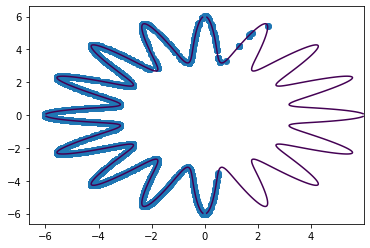

In [41]:
fig, ax = plt.subplots()
xlim = [-6, 6]
ylim = [-6, 6]

ax.contour(*prep_contour(xlim, ylim, 0.01, f), levels=[y])
ax.scatter(*OUTS[0]['SAMPLES'].T)
plt.show()

In [35]:
def HugTangential(x0, δ, B, N, α, q, logpi, grad_log_pi):
    """
    Repurposed version of THUG.
    """
    # The following dictionary stores everything we need
    OUT = {
        'D' : {f"{i}": [] for i in range(N)}, # Distance
        'SD': {f"{i}": [] for i in range(N)}, # Square Distance
        'AR': [np.nan for i in range(N)],     # Acceptance Ratio
        'Δk': [np.nan for i in range(N)],     # Kinetic Energy
        'Δℓ': [np.nan for i in range(N)],     # Potential Energy
        'SAMPLES': x0,
        'ACCEPTANCES': np.zeros(N),
        'EJSD': [np.nan for i in range(N)]    # Acceptance Ratio * Squared Distance
    }
    for i in range(N):
        v0s = q.rvs()                    # Draw velocity spherically
        g = grad_log_pi(x0)              # Compute gradient at x0
        g = g / norm(g)                  # Normalize
        v0 = v0s - α * g * (g @ v0s) # Tilt velocity
        v, x = v0, x0                    # Housekeeping
        logu = np.log(rand())            # Acceptance ratio
        for _ in range(B):
            xmid = x + δ*v/2           # Move to midpoint
            g = grad_log_pi(xmid)          # Compute gradient at midpoint
            ghat = g / norm(g)          # Normalize 
            v = v - 2*(v @ ghat) * ghat # Reflect velocity using midpoint gradient
            x = xmid + δ*v/2           # Move from midpoint to end-point
            # Compute metrics
            OUT['D'][f"{i}"].append(norm(x - x0))
            OUT['SD'][f"{i}"].append(norm(x  -x0)**2)

        # Unsqueeze the velocity
        g = grad_log_pi(x)
        g = g / norm(g)
        v = v + (α / (1 - α)) * g * (g @ v)
        # In the acceptance ratio must use spherical velocities!! Hence v0s and the unsqueezed v
        logar = logpi(x) + q.logpdf(v) - logpi(x0) - q.logpdf(v0s)
        ar = exp(logar)
        OUT['AR'][i] = ar
        OUT['Δk'][i] = - norm(v)**2 + norm(v0s)**2
        OUT['Δℓ'][i] = logpi(x) - logpi(x0)
        OUT['EJSD'][i] = ar * (norm(x - x0)**2)
        if logu <= logar:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x))
            OUT['ACCEPTANCES'][i] = 1         # Accepted!
            x0 = x
        else:
            OUT['SAMPLES'] = np.vstack((OUT['SAMPLES'], x0))
            OUT['ACCEPTANCES'][i] = 0         # Rejected
    return OUT

In [36]:
# Proposal for velocity
q = MVN(zeros(2), eye(2))

# Prior function is uniform on a huge square
square_side = 10  # SQUARE SIDE
logprior  = lambda xi: udist.logpdf(xi, loc=-square_side, scale=2*square_side).sum()

def generate_logpi(ϵ):
    # Kernel
#     def logkernel(xi):
#         with np.errstate(divide='ignore'):
#             return log(float(norm(f(xi) - z0) < ϵ) / ϵ)
    def logkernel(xi):
        return -norm(f(xi) - y)**2/(2*(ϵ**2)) - np.log(ϵ)
    # Logpi
    logpi = lambda xi: logprior(xi) + logkernel(xi)
    return logpi

def generate_output(ϵs, αs, δs):
    OUTS = []
    for ϵix, ϵ in enumerate(ϵs):
        for αix, α in enumerate(αs):
            for δix, δ in enumerate(δs):
                x0 = sample_on_manifold()
                logpi = generate_logpi(ϵ)
                OUTS.append(HugTangential(x0, δ, B, N, α, q, logpi, grad))
    return OUTS

In [37]:
# Settings
ϵ = 0.001
δ = 0.1
B = 20
N = 10000

ϵs = [ϵ]
δs = [δ]
αs = [0.0, 0.5, 0.9, 0.99]

In [38]:
OUTS = generate_output(
    ϵs=ϵs,
    αs=αs,
    δs=δs
)

In [39]:
def percentage_in_interval(iterable, left, right):
    """Counts the number of elements in `iterable` that are contained in the 
    interval `[left, right]`."""
    array = np.array(iterable)
    flag = (left <= array) & (array <= right)
    return (len(array[flag]) / len(array)) * 100

def proportion_lessthan(iterable, value):
    """Proportion of elements in iterable that are less than value."""
    array = np.array(iterable)
    flag = array <= value
    return (sum(flag) / len(array))

def find_value_so_prop_Δℓ_larger_new(iterable, p):
    N = len(iterable)
    return np.sort(np.array(iterable))[int(np.floor(N*np.round(1-p, decimals=2)))]

def generate_Δℓ_table_new(outs, props):
    """This table only works on intervals of the type [L, \infty)."""
    table = zeros((len(outs), len(props)))
    Ls = []
    for p_ix, p in enumerate(props):
        # Find value L so that a proportion p of samples have Δℓ larger than L
        L = find_value_so_prop_Δℓ_larger_new(outs[0]['Δℓ'], p)
        Ls.append(L)
        # Fill in the first row of the table
        table[0, p_ix] = percentage_in_interval(outs[0]['Δℓ'], L, np.inf) # should be p
        # Fill in the rest of the rows for other αs
        for α_ix in range(1, len(outs)):
            table[α_ix, p_ix] = percentage_in_interval(outs[α_ix]['Δℓ'], L, np.inf)
    return table, Ls

def generate_latex_table(table, Ls):
    """Generate table."""
    s  = r"\begin{table}[htp]"         + "\n"
    s += r"\begin{tabular}{l|llll}"    + "\n"
    s += r"& $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ & $\Delta\ell \geq {:.2f}$ \\ \hline".format(*Ls) + "\n"
    s += r"$\alpha = 0$    & {:.0f} & {:.0f} & {:.0f} & {:.0f} \\".format(*table[0, :]) + "\n"
    s += r"$\alpha = 0.5$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[1, :]) + "\n"
    s += r"$\alpha = 0.9$  & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\".format(*table[2, :]) + "\n"
    s += r"$\alpha = 0.99$ & {:.2f} & {:.2f} & {:.2f} & {:.2f}".format(*table[3, :]) + "\n"
    s += r"\end{tabular}" + "\n"
    s += r"\end{table}"
    print(s)

In [40]:
generate_latex_table(*generate_Δℓ_table_new(OUTS, [0.25, 0.5, 0.75, 0.9]))

\begin{table}[htp]
\begin{tabular}{l|llll}
& $\Delta\ell \geq -0.74$ & $\Delta\ell \geq -17.84$ & $\Delta\ell \geq -172.15$ & $\Delta\ell \geq -989.36$ \\ \hline
$\alpha = 0$    & 25 & 50 & 75 & 90 \\
$\alpha = 0.5$  & 36.20 & 64.77 & 85.63 & 95.04 \\
$\alpha = 0.9$  & 54.00 & 73.97 & 87.12 & 94.88 \\
$\alpha = 0.99$ & 52.71 & 72.99 & 86.47 & 94.79
\end{tabular}
\end{table}
